In [1]:
#implementação do circuito de adição proposto por Vedral, Barenco e Ekert, utilizando 3n bits, onde n é número de bits de cada operando

import qiskit
from qiskit.quantum_info import Statevector
n = 3

qc = qiskit.QuantumCircuit(3*n + 1)

In [2]:
#returns a list with the indexes of all qubits in qregs
def get_qubits(qc: qiskit.QuantumCircuit, qregs: list[qiskit.QuantumRegister]) -> list[int]:
    bits = []
    for qreg in qregs:
        n = qc.find_bit(qreg[0]).index
        bits.extend(list(range(n, n+qreg.size)))
    return bits

In [3]:
#applies a not in all bits of a given register acconding to control bit
def cx_reg(num_qubits: int) -> qiskit.QuantumCircuit:
    reg = qiskit.QuantumRegister(num_qubits, name="reg")
    c = qiskit.QuantumRegister(1, name="c")
    qc = qiskit.QuantumCircuit(reg,c)
    for qubit in reg:
        qc.cx(c[0], qubit)
    return qc

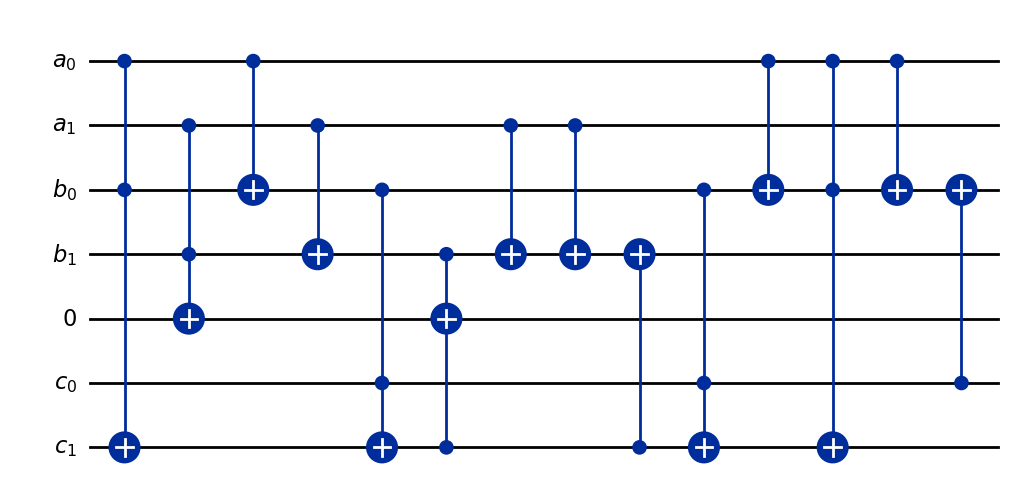

In [32]:
#qc_carry function defines a 4 qubit circuit (carryIn, a, b, carryOut) sets the carry out value accondingly for the sum of a,b,carryIn
def qc_carry() -> qiskit.QuantumCircuit:
    cIn = qiskit.QuantumRegister(1, name="cIn")
    a = qiskit.QuantumRegister(1, name="a")
    b = qiskit.QuantumRegister(1, name="b")
    cOut = qiskit.QuantumRegister(1, name="cOut")
    quantum_circuit = qiskit.QuantumCircuit(cIn, a, b, cOut)

    quantum_circuit.ccx(1, 2, 3)
    quantum_circuit.cx(1, 2)
    quantum_circuit.ccx(0, 2, 3)

    return quantum_circuit

#qc_sum function defines a 3 qubit quantum circuit (a, b, s) and sets the value of s according to the result of the sum from a and b
def qc_sum() -> qiskit.QuantumCircuit:
    c = qiskit.QuantumRegister(1, name="c")
    a = qiskit.QuantumRegister(1, name="a")
    b = qiskit.QuantumRegister(1, name="b")
    quantum_circuit = qiskit.QuantumCircuit(c, a, b)
    quantum_circuit.cx(1,2)
    quantum_circuit.cx(0,2)
    return quantum_circuit



def qc_adder(num_qubits: int) -> qiskit.QuantumCircuit:
    a = qiskit.QuantumRegister(num_qubits, name="a")
    b = qiskit.QuantumRegister(num_qubits, name="b")
    zero = qiskit.QuantumRegister(1, name="0")
    c = qiskit.QuantumRegister(num_qubits, name="c")
    quantum_circuit = qiskit.QuantumCircuit(a, b, zero, c)

    carry_circ = qc_carry()
    sum_circ = qc_sum()

    for i in range(num_qubits):
        quantum_circuit.compose(carry_circ, qubits=[2*num_qubits+1+i, i, num_qubits+i, 2*num_qubits+2+i if i != num_qubits-1 else 2*num_qubits], inplace=True)
    quantum_circuit.cx(num_qubits-1, 2*num_qubits-1)
    quantum_circuit.compose(sum_circ,  qubits=[3*num_qubits, num_qubits-1, 2*num_qubits-1], inplace=True)
    for i in range(num_qubits-1):
        quantum_circuit.compose(carry_circ.inverse(), qubits=[3*num_qubits-1-i, num_qubits-2-i, 2*num_qubits-2-i, 3*num_qubits-i], inplace=True)
        quantum_circuit.compose(sum_circ, qubits=[3*num_qubits-1-i, num_qubits-2-i, 2*num_qubits-2-i], inplace=True)
    return quantum_circuit

qc_adder(2).draw("mpl")


In [93]:
Statevector.from_label("0000011").evolve(qc_adder(2).inverse()).draw("latex")

<IPython.core.display.Latex object>

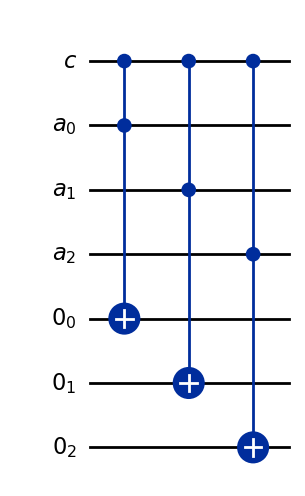

In [94]:
#depending on the control bit state, copies n qubit register into another
def c_copy(num_qubits: int) -> qiskit.QuantumCircuit:
    c = qiskit.QuantumRegister(1, name="c")
    a = qiskit.QuantumRegister(num_qubits, name="a")
    zero = qiskit.QuantumRegister(num_qubits, name="0")
    quantum_circuit = qiskit.QuantumCircuit(c, a, zero)

    for i in range(num_qubits):
        quantum_circuit.ccx(0, i+1, num_qubits+i+1)
    return quantum_circuit

c_copy(3).draw("mpl")

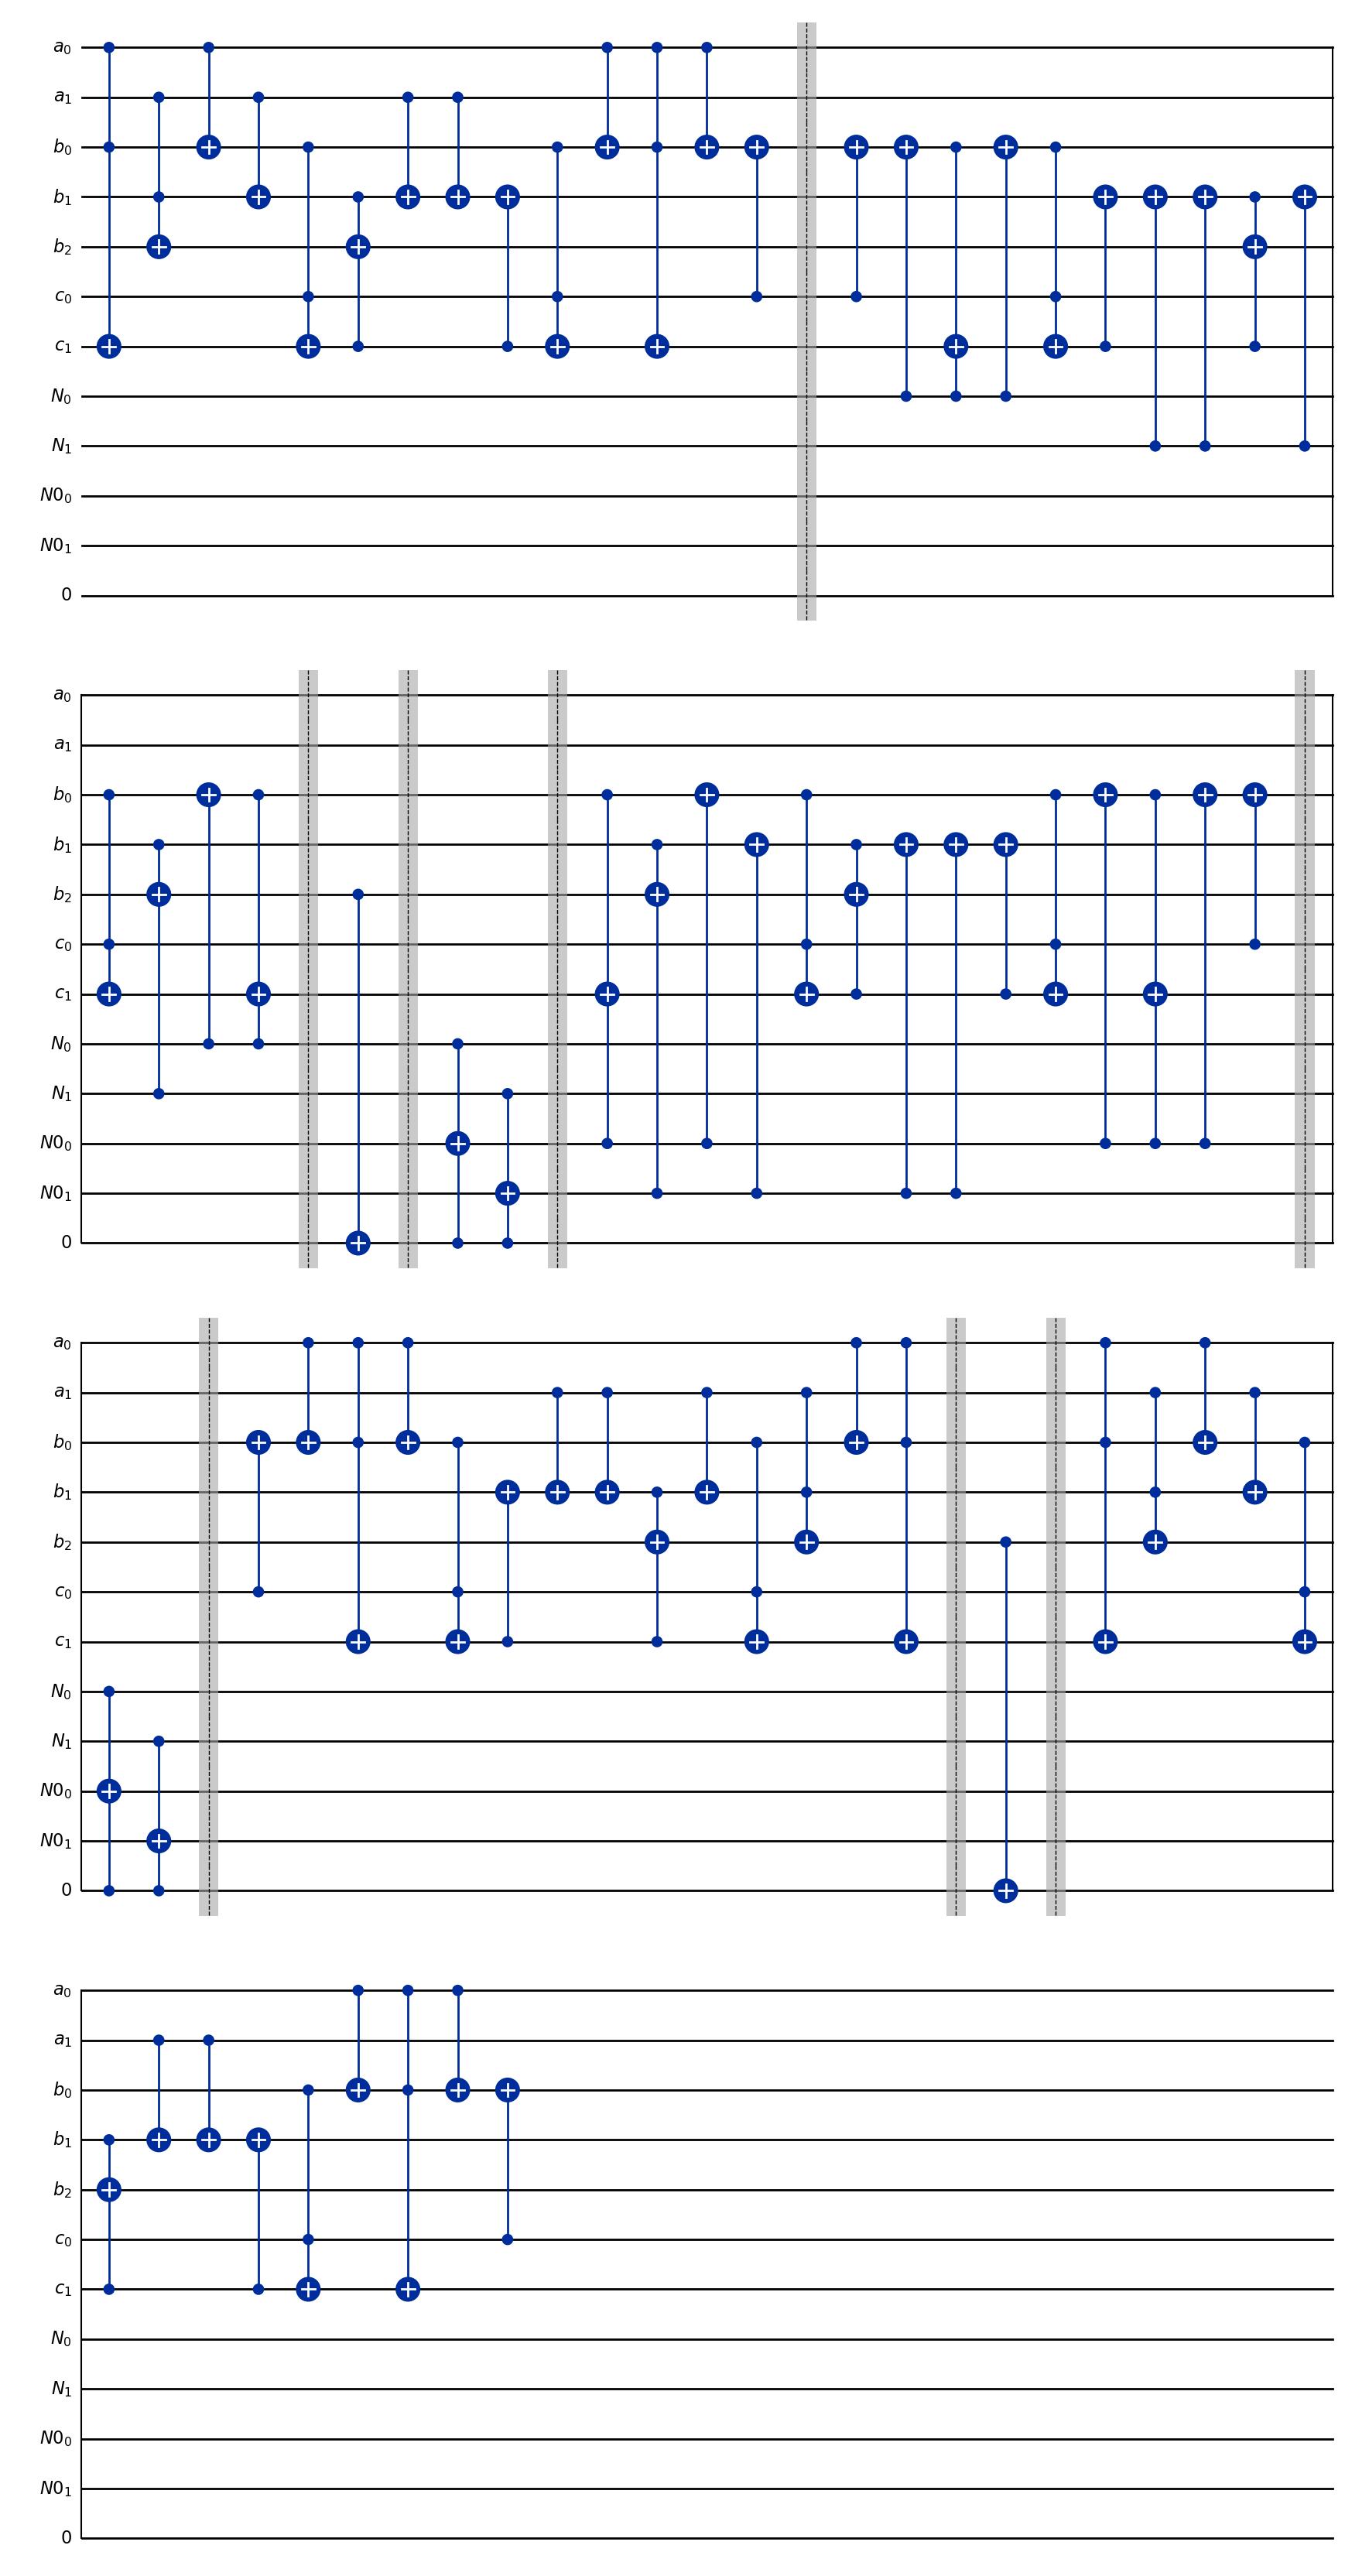

In [97]:
def mod_adder(num_qubits: int) -> qiskit.QuantumCircuit:
    #init work qubits and circuit
    zero = qiskit.QuantumRegister(1, name="0")
    a = qiskit.QuantumRegister(num_qubits, name="a")
    b = qiskit.QuantumRegister(num_qubits + 1, name="b")
    c = qiskit.QuantumRegister(num_qubits, name="c")
    n = qiskit.QuantumRegister(num_qubits, name="N")
    n0 = qiskit.QuantumRegister(num_qubits, name="N0")
    quantum_circuit = qiskit.QuantumCircuit(a, b, c, n, n0, zero)
    
    #defining circs
    adder_circ = qc_adder(num_qubits)
    c_copy_circ = c_copy(num_qubits)

    quantum_circuit.compose(adder_circ, qubits=get_qubits(quantum_circuit, [a,b,c]), inplace=True)
    quantum_circuit.barrier()
    quantum_circuit.compose(adder_circ.inverse(), qubits=get_qubits(quantum_circuit, [n,b,c]), inplace=True)
    quantum_circuit.barrier()
    quantum_circuit.cx(b[-1], zero[0])
    quantum_circuit.barrier()
    quantum_circuit.compose(c_copy_circ, qubits=get_qubits(quantum_circuit, [zero, n, n0]), inplace=True)
    quantum_circuit.barrier()
    quantum_circuit.compose(adder_circ, qubits=get_qubits(quantum_circuit, [n0,b,c]), inplace=True)
    quantum_circuit.barrier()
    quantum_circuit.compose(c_copy_circ, qubits=get_qubits(quantum_circuit, [zero, n, n0]), inplace=True)
    quantum_circuit.barrier()
    quantum_circuit.compose(adder_circ.inverse(), qubits=get_qubits(quantum_circuit, [a,b,c]), inplace=True)
    quantum_circuit.barrier()
    quantum_circuit.cx(b[-1], zero[0])
    quantum_circuit.barrier()
    quantum_circuit.compose(adder_circ, qubits=get_qubits(quantum_circuit, [a,b,c]), inplace=True)
    return quantum_circuit

mod_adder(2).draw("mpl")

In [110]:
Statevector.from_label("000110001010").evolve(mod_adder(2)).draw("latex")

<IPython.core.display.Latex object>